In [3]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
# pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field
from skimage.transform import resize

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate

In [6]:
b_cube = np.load('/mnt/userdata/jeon_mg/low_lou_test/test/case2.npz')['b'].astype(np.float32)

In [7]:
b_cube.shape

(80, 80, 72, 3)

In [8]:
b_cube = b_cube[:, :, :-8]
b_cube.shape

(80, 80, 64, 3)

In [9]:
b_bottom = b_cube[:, :, 0, :]
b_bottom.shape

(80, 80, 3)

In [12]:
meta_path = Path("/userhome/jeon_mg/workspace/base/uno_pi_cc_hnorm_unit_aug_ccc_square_energy_lowlou")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
model_input = b_bottom

In [14]:
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

torch.Size([1, 1, 80, 80, 3])

In [15]:
model_output = model(model_input)

In [16]:
model_output.shape

torch.Size([1, 64, 80, 80, 3])

In [17]:
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [18]:
b.shape

(80, 80, 64, 3)

In [20]:
evaluate(b[8:-8, 8:-8, :], b_cube[8:-8, 8:-8, :])

C_vec     : 0.9971
C_cs      : 0.9931
E_n'      : 0.8667
E_m'      : 0.7960
eps       : 0.9013
CW_sin    : 0.3101
L_f       : 0.2760
L_d       : 0.2378
l2_err    : 0.0896


{'C_vec': 0.9971235655585933,
 'C_cs': 0.9930657392202934,
 "E_n'": 0.8667425774234481,
 "E_m'": 0.7959918966733073,
 'eps': 0.9013426107865202,
 'CW_sin': 0.31012048686026483,
 'L_f': 0.27602420373728237,
 'L_d': 0.23777537900531645,
 'l2_err': 0.08957217963330438}

In [19]:
evaluate(b, b_cube)

C_vec     : 0.9965
C_cs      : 0.9722
E_n'      : 0.8421
E_m'      : 0.7404
eps       : 0.9007
CW_sin    : 0.3766
L_f       : 0.2026
L_d       : 0.1639
l2_err    : 0.0965


{'C_vec': 0.9964601691305557,
 'C_cs': 0.9722036472690081,
 "E_n'": 0.8421256896822362,
 "E_m'": 0.7404265108902142,
 'eps': 0.9007267568248308,
 'CW_sin': 0.3765552476736335,
 'L_f': 0.2025714204984415,
 'L_d': 0.16391660715953824,
 'l2_err': 0.0965064976544806}

In [36]:
evaluate(b, b_cube)

C_vec     : 0.9932
C_cs      : 0.9477
E_n'      : 0.7949
E_m'      : 0.6607
eps       : 0.8885
CW_sin    : 0.4347
L_f       : 0.3235
L_d       : 0.1864
l2_err    : 0.1271


{'C_vec': 0.9931833766253826,
 'C_cs': 0.9476605838561268,
 "E_n'": 0.7949101871109887,
 "E_m'": 0.6607380248986963,
 'eps': 0.8885260282786219,
 'CW_sin': 0.4346530390166252,
 'L_f': 0.3234560905463298,
 'L_d': 0.18642935135689734,
 'l2_err': 0.12706265382269671}

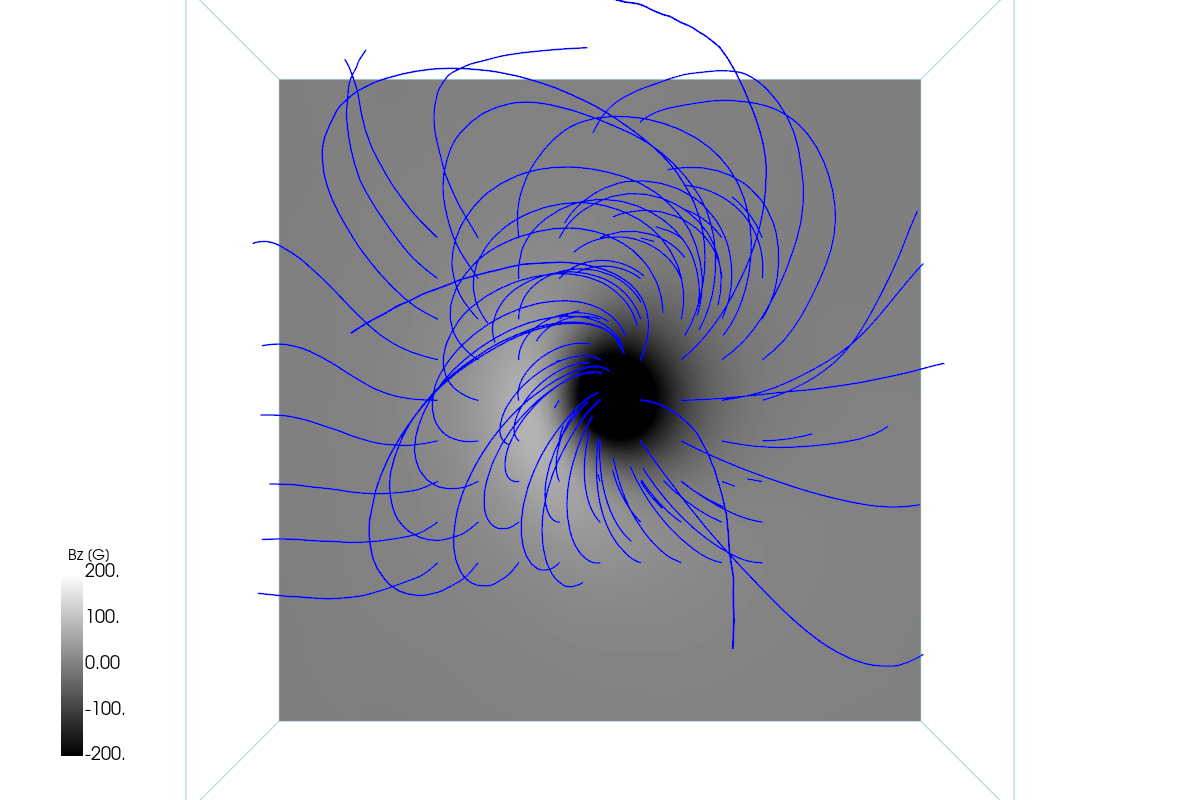

In [37]:
vmin = -200
vmax = 200
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

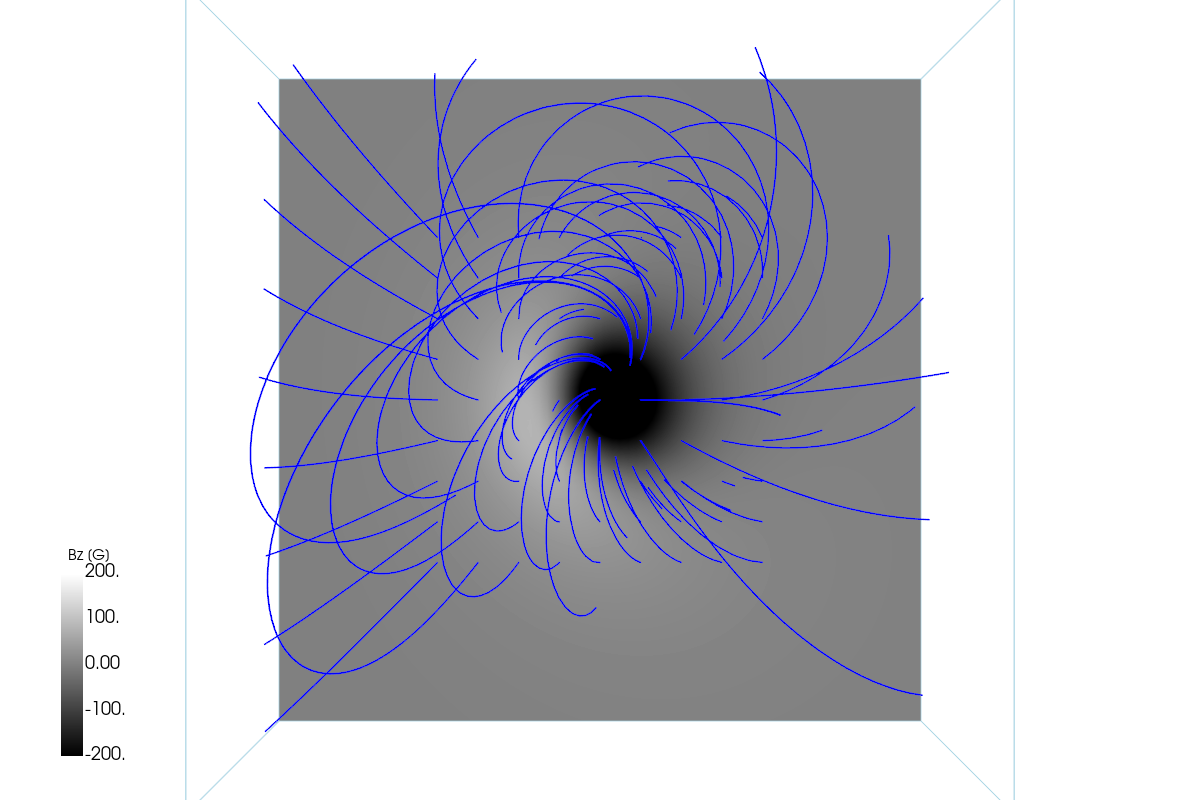

In [38]:
vmin = -200
vmax = 200
i_siz=b_cube.shape[0] / 2
j_siz=b_cube.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b_cube[..., 0]
by = b_cube[..., 1]
bz = b_cube[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()